In [ ]:
from prompt_toolkit.formatted_text import to_plain_text
%pip install duckdb
%pip install geopandas
%pip install tabulate
%pip install matplotlib
%pip install contextily

In [13]:
import duckdb
import h3
import folium
from shapely.geometry import MultiPolygon, Polygon
from IPython.display import display
import pandas as pd
import json


Read restaurant locations

In [329]:
filename="./restaurants.json"
lines=[]
N=250
with open(filename, 'r') as infile:
    lines = [line for line in infile][:N]
#print(lines)

for line in lines:
    json_line = json.loads(line)
    #print(f"name: {json_line['name']} , location: {json_line['location']['coordinates']}")

# Define DataFrame
df = pd.DataFrame(columns=["Name", "Lon", "Lat"])

# Parse each line and add to DataFrame
for line in lines:
    json_line = json.loads(line)
    df.loc[len(df)]={"Name":json_line['name'], "Lon":json_line['location']['coordinates'][0], "Lat":json_line['location']['coordinates'][1] }

from tabulate import tabulate
#print(tabulate(df, headers = 'keys', tablefmt = 'psql'))
df.head(10)



,Name,Lon,Lat
0,Morris Park Bake Shop,-73.856077,40.848447
1,Wendy'S,-73.961704,40.662942
2,Riviera Caterer,-73.982420,40.579505
3,Tov Kosher Kitchen,-73.860115,40.731174
4,Brunos On The Boulevard,-73.880383,40.764312
5,Dj Reynolds Pub And Restaurant,-73.985136,40.767692
6,Wilken'S Fine Food,-73.906851,40.619903
7,Regina Caterers,-74.005289,40.628886
8,Taste The Tropics Ice Cream,-73.948261,40.640827
9,Kosher Island,-74.137729,40.611957


Store restaurant data set into CSV file so that we can upload to DuckDB

In [330]:
df.to_csv("./restaurants.csv",index=False)

In [188]:
from os import listdir
from os.path import isfile, join
mypath="./"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and f.endswith(".csv")]
onlyfiles

['restaurants.csv']

In [190]:
def listFilesInWithExtension(target_path, target_ext=".csv"):
    if target_path:
        return [f for f in listdir(target_path) if isfile(join(target_path, f)) and f.endswith(target_ext)]
    else:
        return None

In [18]:
duckdb.sql("SELECT 'whistling_duck' AS waterfowl, 'whistle' AS call")

┌────────────────┬─────────┐
│   waterfowl    │  call   │
│    varchar     │ varchar │
├────────────────┼─────────┤
│ whistling_duck │ whistle │
└────────────────┴─────────┘

Let's load restaurants.csv file as a table to food-delivery.db

In [ ]:
with duckdb.connect(database="food-delivery.db") as conn:
    conn.read_csv("./restaurants.csv").to_table("restaurants")
    conn.close()


In [191]:
listFilesInWithExtension("./",target_ext=".db")

['food-delivery.db', 'my_database.db']

In [49]:
answer=None

with duckdb.connect(database="food-delivery.db") as conn:
    answer=conn.sql("SELECT * FROM restaurants2")
    answer
    conn.close()


In [194]:
con = duckdb.connect('food-delivery.db')

results = con.sql("SHOW ALL TABLES").fetchall()
print(type(results))
for result in results:
    print(result)

results = con.sql("SELECT Name, Lon, Lat FROM restaurants").fetchall()
print(type(results))
for result in results:
    print(result)

<class 'list'>
('food-delivery', 'main', 'restaurants', ['Name', 'Lon', 'Lat', 'geom', 'h3_cell_id'], ['VARCHAR', 'DOUBLE', 'DOUBLE', 'GEOMETRY', 'BIGINT'], False)
('food-delivery', 'main', 'restaurants-2', ['Name', 'Lon', 'Lat'], ['VARCHAR', 'DOUBLE', 'DOUBLE'], False)
('food-delivery', 'main', 'restaurants2', ['Name', 'Lon', 'Lat'], ['VARCHAR', 'DOUBLE', 'DOUBLE'], False)
<class 'list'>
('Morris Park Bake Shop', -73.856077, 40.848447)
("Wendy'S", -73.961704, 40.662942)
('Riviera Caterer', -73.98241999999999, 40.579505)
('Tov Kosher Kitchen', -73.8601152, 40.7311739)
('Brunos On The Boulevard', -73.8803827, 40.7643124)
('Dj Reynolds Pub And Restaurant', -73.98513559999999, 40.7676919)
("Wilken'S Fine Food", -73.9068506, 40.6199034)
('Regina Caterers', -74.00528899999999, 40.628886)
('Taste The Tropics Ice Cream', -73.9482609, 40.6408271)
('Kosher Island', -74.1377286, 40.6119572)
('Wild Asia', -73.8786113, 40.8502883)
('C & C Catering Service', -73.9973325, 40.61174889999999)
('1 East

Let's add new geom column to restaurants table.
<br> ST_Transform()
<br> ST_Poin()

In [211]:
%%time
query = """
INSTALL spatial; LOAD spatial;
ALTER TABLE restaurants ADD COLUMN geom GEOMETRY;
UPDATE restaurants
    SET geom = ST_Transform(ST_Point(lat, lon), 'EPSG:4326', 'EPSG:2154');
"""
tbl_restaurants.sql(query)

CPU times: total: 0 ns
Wall time: 659 μs


AttributeError: This relation does not contain a column by the name of 'sql'

In [224]:
%%time
con = duckdb.connect('food-delivery.db')
query = """
UPDATE restaurants
    SET geom = ST_Point(lat, lon);
"""
con.sql(query)

CPU times: total: 0 ns
Wall time: 3.44 ms


Let's retrieve the name and location of restaurants

In [227]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
SELECT name, Lon, Lat, geom FROM restaurants;
"""
df_select = con.sql(query).df()

CPU times: total: 0 ns
Wall time: 3.31 ms


In [228]:
df_select[:10]

,Name,Lon,Lat,geom
0,Morris Park Bake Shop,-73.856077,40.848447,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,Wendy'S,-73.961704,40.662942,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,Riviera Caterer,-73.982420,40.579505,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,Tov Kosher Kitchen,-73.860115,40.731174,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,Brunos On The Boulevard,-73.880383,40.764312,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
5,Dj Reynolds Pub And Restaurant,-73.985136,40.767692,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
6,Wilken'S Fine Food,-73.906851,40.619903,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
7,Regina Caterers,-74.005289,40.628886,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
8,Taste The Tropics Ice Cream,-73.948261,40.640827,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
9,Kosher Island,-74.137729,40.611957,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


Some helper functions

In [263]:
def vis_add_circle(m, lat, lon, r,color="cornflowerblue"):
    circle = folium.CircleMarker(
                location=[lat, lon],
                radius=r,
                color=color,
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                opacity=1,
                popup="{} pixels".format(r),
                tooltip="I am NNQ",
    )
    m.add_child(circle)


def visualize_poi(df_selected, nnq_lon=None, nnq_lat=None, radius=10, color="red"):
    """
        Visualize a polygon by using folium
    :param polyline:
    :param color:
    :return:
    """

    m = folium.Map(location=[sum(df_selected.Lat)/len(df_selected.Lat), sum(df_selected.Lon)/len(df_selected.Lon)], zoom_start=10, tiles='Cartodb Positron')
    if nnq_lat and nnq_lon:
        vis_add_circle(m, nnq_lat, nnq_lon, radius, color="red")
    #my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    #m.add_child(my_PolyLine)
    for index, row in df.iterrows():
        r=5
        circle = folium.CircleMarker(
                location=[row['Lat'], row['Lon']],
                radius=r,
                color="cornflowerblue",
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                opacity=1,
                popup="{} pixels".format(r),
                tooltip=row['Name'],
            )
        m.add_child(circle)

    return m


Let's see the locations on a map

In [202]:
m = visualize_poi(df_select,None,None)
display(m)

## kNN Query
<br>

In [218]:
NNQ_LON=-73.8601152
NNQ_LAT= 40.7311739
NNQ_RADIUS = 110


In [219]:
m = visualize_poi(df_select, NNQ_LON, NNQ_LAT, NNQ_RADIUS)
display(m)

The circle in red denotes the range of query.

In [239]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
SELECT name
    , Lon
    , Lat
    , ST_Distance(geom, ST_Point({NNQ_LON}, {NNQ_LAT})) AS dist2NNQ
FROM restaurants
"""
df_select = con.sql(query).df()

CPU times: total: 0 ns
Wall time: 4.27 ms


In [243]:
df_select.sort_values(by='dist2NNQ', ascending=True, inplace=True)
df_select

,Name,Lon,Lat,dist2NNQ
16,Carvel Ice Cream,-73.703260,40.738642,161.950964
6,Wilken'S Fine Food,-73.906851,40.619903,162.010960
13,May May Kitchen,-73.871194,40.673097,162.023330
2,Riviera Caterer,-73.982420,40.579505,162.035907
14,Seuda Foods,-73.965397,40.606434,162.042878
8,Taste The Tropics Ice Cream,-73.948261,40.640827,162.055048
3,Tov Kosher Kitchen,-73.860115,40.731174,162.056555
11,C & C Catering Service,-73.997332,40.611749,162.069238
19,Sal'S Deli,-73.839297,40.781470,162.077407
15,Carvel Ice Cream,-73.978220,40.643525,162.078157


In [258]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
SELECT name, Lon, Lat FROM restaurants
WHERE ST_DWithin(geom, ST_Point({NNQ_LON}, {NNQ_LAT}), {NNQ_RADIUS}*1.4734);
"""
df_select = con.sql(query).df()

CPU times: total: 0 ns
Wall time: 4.97 ms


In [259]:
df_select

,Name,Lon,Lat
0,Riviera Caterer,-73.982420,40.579505
1,Tov Kosher Kitchen,-73.860115,40.731174
2,Wilken'S Fine Food,-73.906851,40.619903
3,Taste The Tropics Ice Cream,-73.948261,40.640827
4,C & C Catering Service,-73.997332,40.611749
5,May May Kitchen,-73.871194,40.673097
6,Seuda Foods,-73.965397,40.606434
7,Carvel Ice Cream,-73.703260,40.738642


In [264]:
m = visualize_poi(df_select, NNQ_LON, NNQ_LAT, NNQ_RADIUS)
display(m)

Let's analyze the query plan to verify table scan

In [246]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
EXPLAIN ANALYZE
SELECT name, Lon, Lat FROM restaurants
WHERE ST_DWithin(geom, ST_Point({NNQ_LON}, {NNQ_LAT}), {NNQ_RADIUS}*1.4734);
"""
query_plan = con.sql(query).fetchall()

CPU times: total: 0 ns
Wall time: 3.75 ms


In [254]:
analyzed_plan = query_plan[0][1]
analyzed_plan

for line in analyzed_plan.split('\n'):
    print(line)

with open('./qa_st_dwithin.txt', 'w', encoding="utf-8") as f:
    f.writelines(analyzed_plan)
    f.close()


┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
 EXPLAIN ANALYZE SELECT name, Lon, Lat FROM restaurants WHERE ST_DWithin(geom, ST_Point(-73.8601152, 40.7311739), 110*1.4734); 
┌────────────────────────────────────────────────┐
│┌──────────────────────────────────────────────┐│
││              Total Time: 0.0015s             ││
│└──────────────────────────────────────────────┘│
└────────────────────────────────────────────────┘
┌───────────────────────────┐
│           QUERY           │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│      EXPLAIN_ANALYZE      │
│    ────────────────────   │
│           0 rows          │
│          (0.00s)          │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│         TABLE_SCAN        │
│    ────────────────────   │
│     Table: restaurants    │
│   Type: Sequential Scan  

As the query plan shows, it scans the table.

In [265]:
%%time
query = "CREATE INDEX spatial_index ON restaurants USING RTREE (geom);"
con.sql(query)


CPU times: total: 0 ns
Wall time: 4.07 ms


In [316]:
MNNQ_RADIUS = (NNQ_RADIUS*1.4734)*0.7075

In [285]:
%%time
query = f"SELECT ST_MakeEnvelope({NNQ_LON}-{MNNQ_RADIUS}, {NNQ_LAT}-{MNNQ_RADIUS},{NNQ_LON}+{MNNQ_RADIUS}, {NNQ_LAT}+{MNNQ_RADIUS}) AS envelope;"
dfr = con.sql(query).df()
dfr

CPU times: total: 0 ns
Wall time: 1.93 ms


,envelope
0,"[2, 4, 0, 0, 0, 0, 0, 0, 170, 229, 26, 195, 43..."


In [317]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
SET VARIABLE envelope = ST_MakeEnvelope({NNQ_LON}-{MNNQ_RADIUS}, {NNQ_LAT}-{MNNQ_RADIUS},{NNQ_LON}+{MNNQ_RADIUS}, {NNQ_LAT}+{MNNQ_RADIUS});
SELECT name, Lon, Lat
FROM restaurants
WHERE ST_Within(geom,getvariable('envelope'));
"""
df_select = con.sql(query).df()

CPU times: total: 0 ns
Wall time: 4.8 ms


In [318]:
df_select

,Name,Lon,Lat
0,Tov Kosher Kitchen,-73.860115,40.731174
1,Brunos On The Boulevard,-73.880383,40.764312
2,Wilken'S Fine Food,-73.906851,40.619903
3,May May Kitchen,-73.871194,40.673097
4,Carvel Ice Cream,-73.703260,40.738642
5,Sal'S Deli,-73.839297,40.781470


In [327]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
SET VARIABLE envelope = ST_MakeEnvelope({NNQ_LON}-{MNNQ_RADIUS}, {NNQ_LAT}-{MNNQ_RADIUS},{NNQ_LON}+{MNNQ_RADIUS}, {NNQ_LAT}+{MNNQ_RADIUS});

EXPLAIN ANALYZE
SELECT name, Lon, Lat
FROM restaurants
--WHERE ST_Within(geom, getvariable('envelope'));
WHERE ST_Contains(getvariable('envelope'),geom);
"""
query_plan = con.sql(query).fetchall()

CPU times: total: 0 ns
Wall time: 5 ms


In [328]:
analyzed_plan = query_plan[0][1]
analyzed_plan

for line in analyzed_plan.split('\n'):
    print(line)

with open('./qa_st_dwithin_rtree.txt', 'w', encoding="utf-8") as f:
    f.writelines(analyzed_plan)
    f.close()

┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
  EXPLAIN ANALYZE SELECT name, Lon, Lat FROM restaurants --WHERE ST_Within(geom, getvariable('envelope')); WHERE ST_Contains(getvariable('envelope'),geom); 
┌────────────────────────────────────────────────┐
│┌──────────────────────────────────────────────┐│
││              Total Time: 0.0015s             ││
│└──────────────────────────────────────────────┘│
└────────────────────────────────────────────────┘
┌───────────────────────────┐
│           QUERY           │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│      EXPLAIN_ANALYZE      │
│    ────────────────────   │
│           0 rows          │
│          (0.00s)          │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│         PROJECTION        │
│    ────────────────────   │
│            Name           

In [266]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
SELECT name, Lon, Lat FROM restaurants
WHERE ST_DWithin(geom, ST_Point({NNQ_LON}, {NNQ_LAT}), {NNQ_RADIUS}*1.4734);
"""
df_select = con.sql(query).df()

CPU times: total: 0 ns
Wall time: 3.84 ms


In [267]:
df_select

,Name,Lon,Lat
0,Riviera Caterer,-73.982420,40.579505
1,Tov Kosher Kitchen,-73.860115,40.731174
2,Wilken'S Fine Food,-73.906851,40.619903
3,Taste The Tropics Ice Cream,-73.948261,40.640827
4,C & C Catering Service,-73.997332,40.611749
5,May May Kitchen,-73.871194,40.673097
6,Seuda Foods,-73.965397,40.606434
7,Carvel Ice Cream,-73.703260,40.738642


In [268]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
EXPLAIN ANALYZE
SELECT name, Lon, Lat FROM restaurants
WHERE ST_DWithin(geom, ST_Point({NNQ_LON}, {NNQ_LAT}), {NNQ_RADIUS}*1.4734);
"""
query_plan = con.sql(query).fetchall()

CPU times: total: 0 ns
Wall time: 4.05 ms


In [269]:
analyzed_plan = query_plan[0][1]
analyzed_plan

for line in analyzed_plan.split('\n'):
    print(line)

with open('./qa_st_dwithin_rtree.txt', 'w', encoding="utf-8") as f:
    f.writelines(analyzed_plan)
    f.close()

┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
 EXPLAIN ANALYZE SELECT name, Lon, Lat FROM restaurants WHERE ST_DWithin(geom, ST_Point(-73.8601152, 40.7311739), 110*1.4734); 
┌────────────────────────────────────────────────┐
│┌──────────────────────────────────────────────┐│
││              Total Time: 0.0015s             ││
│└──────────────────────────────────────────────┘│
└────────────────────────────────────────────────┘
┌───────────────────────────┐
│           QUERY           │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│      EXPLAIN_ANALYZE      │
│    ────────────────────   │
│           0 rows          │
│          (0.00s)          │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│         TABLE_SCAN        │
│    ────────────────────   │
│     Table: restaurants    │
│   Type: Sequential Scan  

In [65]:
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:4326", "EPSG:2154", always_xy=True)
x_2154, y_2154 = transformer.transform(NNQ_LON, NNQ_LAT)

In [66]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
SELECT name, Lon, Lat FROM restaurants
--WHERE ST_DWithin(geom, ST_Point({x_2154}, {y_2154}), {NNQ_RADIUS});
WHERE ST_DWithin(geom, ST_Point({x_2154}, {y_2154}), {NNQ_RADIUS});
"""
df_select = con.sql(query).df()

CPU times: total: 15.6 ms
Wall time: 3.56 ms


In [192]:
duckdb.sql("SELECT * FROM restaurants")

CatalogException: Catalog Error: Table with name restaurants does not exist!
Did you mean "pg_prepared_statements"?

In [29]:
tbl_restaurants = duckdb.read_csv("./restaurants.csv")

In [30]:
duckdb.sql("SELECT * FROM restaurants")

CatalogException: Catalog Error: Table with name restaurants does not exist!
Did you mean "pg_prepared_statements"?

In [35]:
tbl_restaurants = duckdb.read_csv("./restaurants.csv")

answer=tbl_restaurants.select("*")
answer

┌────────────────────────────────┬────────────────────┬────────────┐
│              Name              │        Lon         │    Lat     │
│            varchar             │       double       │   double   │
├────────────────────────────────┼────────────────────┼────────────┤
│ Morris Park Bake Shop          │         -73.856077 │  40.848447 │
│ Wendy'S                        │         -73.961704 │  40.662942 │
│ Riviera Caterer                │ -73.98241999999999 │  40.579505 │
│ Tov Kosher Kitchen             │        -73.8601152 │ 40.7311739 │
│ Brunos On The Boulevard        │        -73.8803827 │ 40.7643124 │
│ Dj Reynolds Pub And Restaurant │ -73.98513559999999 │ 40.7676919 │
│ Wilken'S Fine Food             │        -73.9068506 │ 40.6199034 │
│ Regina Caterers                │ -74.00528899999999 │  40.628886 │
│ Taste The Tropics Ice Cream    │        -73.9482609 │ 40.6408271 │
│ Kosher Island                  │        -74.1377286 │ 40.6119572 │
│       ·                        │

In [38]:
%%time
answer=tbl_restaurants.select("*").filter("Name LIKE 'B%'")
answer

CPU times: total: 0 ns
Wall time: 1.76 ms


┌─────────────────────────┬─────────────┬────────────┐
│          Name           │     Lon     │    Lat     │
│         varchar         │   double    │   double   │
├─────────────────────────┼─────────────┼────────────┤
│ Brunos On The Boulevard │ -73.8803827 │ 40.7643124 │
│ Bully'S Deli            │ -73.9925306 │ 40.7309346 │
└─────────────────────────┴─────────────┴────────────┘

In [58]:
%%time
con = duckdb.connect('food-delivery.db')
query = """
INSTALL spatial; LOAD spatial;
ALTER TABLE restaurants ADD COLUMN geom GEOMETRY;
UPDATE restaurants SET geom = ST_Transform(
  ST_Point(Lat, Lon), 'EPSG:4326', 'EPSG:2154'
);"""
qresults=con.sql(query)
qresults

CPU times: total: 1.53 s
Wall time: 2.09 s


AttributeError: 'NoneType' object has no attribute 'fetchall'

In [67]:
df_select

,Name,Lon,Lat
0,Tov Kosher Kitchen,-73.860115,40.731174
1,Brunos On The Boulevard,-73.880383,40.764312
2,May May Kitchen,-73.871194,40.673097
3,Sal'S Deli,-73.839297,40.781470
4,Glorious Food,-73.951710,40.767461
5,Steve Chu'S Deli & Grocery,-73.940247,40.762329


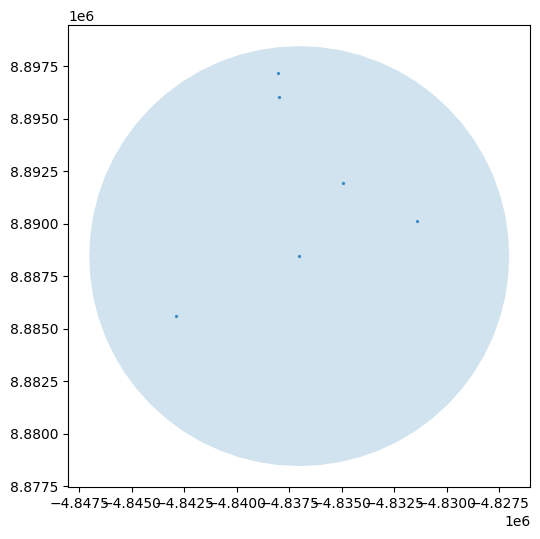

In [84]:
import contextily as cx
import xyzservices.providers as xyz
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

gdf_select_1 = gpd.GeoDataFrame(
        df_select["Name"],
        geometry=gpd.points_from_xy(df_select.Lon, df_select.Lat),
        crs="EPSG:4326",
    )
gdf_select_1 = gdf_select_1.to_crs("EPSG:2154")
ax = gdf_select_1.plot(markersize=2, alpha=0.7, figsize=(6, 6))
point = Point(x_2154, y_2154)
buffer = point.buffer(NNQ_RADIUS)
buffer_gdf = gpd.GeoDataFrame(geometry=[buffer], crs="EPSG:2154")
ax = buffer_gdf.plot(ax=ax, alpha=0.2)

try:
    #
    cx.add_basemap(
        ax,
        source=xyz.CartoDB.VoyagerNoLabels,
        crs=gdf_select_1.crs.to_string(),
        alpha=0.8,
    )
except:
    pass
_ = plt.axis("on")

In [100]:
m = visualize_poi(df_select,NNQ_LON,NNQ_LAT)
display(m)

In [101]:
%%time
query = "CREATE INDEX spatial_index ON restaurants USING RTREE (geom);"
con.sql(query)
answer = con.sql("SHOW ALL TABLES").fetchall()
answer

CPU times: total: 15.6 ms
Wall time: 17 ms


[('food-delivery',
  'main',
  'restaurants',
  ['Name', 'Lon', 'Lat', 'geom'],
  ['VARCHAR', 'DOUBLE', 'DOUBLE', 'GEOMETRY'],
  False),
 ('food-delivery',
  'main',
  'restaurants-2',
  ['Name', 'Lon', 'Lat'],
  ['VARCHAR', 'DOUBLE', 'DOUBLE'],
  False),
 ('food-delivery',
  'main',
  'restaurants2',
  ['Name', 'Lon', 'Lat'],
  ['VARCHAR', 'DOUBLE', 'DOUBLE'],
  False)]

In [107]:
query_str="""
    SELECT TABLE_CATALOG, TABLE_SCHEMA, TABLE_NAME, TABLE_TYPE
    FROM INFORMATION_SCHEMA.TABLES
    WHERE TABLE_NAME = 'restaurants'
    """
answer=con.sql(query_str).df()
answer

,table_catalog,table_schema,table_name,table_type
0,food-delivery,main,restaurants,BASE TABLE


In [109]:
query_str="""
    SELECT TABLE_CATALOG, TABLE_NAME
        , COLUMN_NAME, DATA_TYPE, IS_NULLABLE, column_default
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE   TABLE_CATALOG = 'food-delivery'
        AND TABLE_NAME = 'restaurants'
    """
answer=con.sql(query_str).df()
answer


,table_catalog,table_name,column_name,data_type,is_nullable,column_default
0,food-delivery,restaurants,Name,VARCHAR,YES,None
1,food-delivery,restaurants,Lon,DOUBLE,YES,None
2,food-delivery,restaurants,Lat,DOUBLE,YES,None
3,food-delivery,restaurants,geom,GEOMETRY,YES,None


In [111]:
%%time
query = f"""
SELECT name, Lon, Lat FROM restaurants
WHERE ST_DWithin(geom, ST_Point({x_2154}, {y_2154}), {NNQ_RADIUS});"""
df_select = con.sql(query).df()

CPU times: total: 0 ns
Wall time: 2.65 ms


In [112]:
df_select

,Name,Lon,Lat
0,Tov Kosher Kitchen,-73.860115,40.731174
1,Brunos On The Boulevard,-73.880383,40.764312
2,May May Kitchen,-73.871194,40.673097
3,Sal'S Deli,-73.839297,40.781470
4,Glorious Food,-73.951710,40.767461
5,Steve Chu'S Deli & Grocery,-73.940247,40.762329


In [113]:
query = """
INSTALL h3 FROM community; LOAD h3;"""
con.sql(query)

In [114]:
query = """
DROP INDEX IF EXISTS spatial_index;"""
con.sql(query)

In [116]:
%%time
RESOLUTION=7
query = f"""
ALTER TABLE restaurants ADD COLUMN IF NOT EXISTS h3_cell_id BIGINT;
UPDATE restaurants
  SET h3_cell_id = h3_latlng_to_cell(Lat, Lon, {RESOLUTION});
CREATE INDEX h3_index ON restaurants (h3_cell_id)"""
con.sql(query)

CPU times: total: 0 ns
Wall time: 6.11 ms


In [149]:
RESOLUTION = 7
NNQ_RADIUS = 10000

h3_cell = h3.latlng_to_cell(NNQ_LAT, NNQ_LON, RESOLUTION)
print(f" LAT:{NNQ_LAT} LON:{NNQ_LON} resolution:{RESOLUTION} -> {h3_cell}")

h3_neighbors = h3.grid_disk(h3_cell, 1)  # Center + 1st ring
print(type(h3_neighbors))
h3_neighbors

 LAT:40.7311739 LON:-73.8601152 resolution:7 -> 872a100c5ffffff
<class 'list'>


['872a100c5ffffff',
 '872a100c4ffffff',
 '872a100c0ffffff',
 '872a100c1ffffff',
 '872a100eaffffff',
 '872a100eeffffff',
 '872a100e3ffffff']

In [163]:
query = f"""
WITH query_h3 AS (
  SELECT h3_latlng_to_cell({NNQ_LAT}, {NNQ_LON}, {RESOLUTION}) AS h3
),
nearby_h3 AS (
  SELECT CAST(unnest(h3_grid_disk(h3, 1)) AS BIGINT) AS h3
  FROM query_h3
)
SELECT * FROM nearby_h3;
"""
df_select = con.sql(query).df()

In [175]:
df_comp = pd.concat([df_select, pd.DataFrame(h3_neighbors)],axis=1)
df_comp

,h3,0
0,608725924342398975,872a100c5ffffff
1,608725924325621759,872a100c4ffffff
2,608725924258512895,872a100c0ffffff
3,608725924275290111,872a100c1ffffff
4,608725924963155967,872a100eaffffff
5,608725925030264831,872a100eeffffff
6,608725924845715455,872a100e3ffffff


In [182]:
#df = df.apply(lambda x: np.square(x) if x.name == 'd' else x, axis=1)
hex_df_select = df_select.apply(lambda x: hex(x) if x.name == 'h3' else x, axis=1)
hex_df_select

,h3
0,608725924342398975
1,608725924325621759
2,608725924258512895
3,608725924275290111
4,608725924963155967
5,608725925030264831
6,608725924845715455


In [140]:
%%time
query = f"""
SELECT * FROM restaurants;
"""
df_select = con.sql(query).df()

CPU times: total: 0 ns
Wall time: 2.16 ms


In [141]:
df_select

,Name,Lon,Lat,geom,h3_cell_id
0,Morris Park Bake Shop,-73.856077,40.848447,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725921540603903
1,Wendy'S,-73.961704,40.662942,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725924711497727
2,Riviera Caterer,-73.982420,40.579505,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725952226131967
3,Tov Kosher Kitchen,-73.860115,40.731174,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725924342398975
4,Brunos On The Boulevard,-73.880383,40.764312,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725925080596479
5,Dj Reynolds Pub And Restaurant,-73.985136,40.767692,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725924627611647
6,Wilken'S Fine Food,-73.906851,40.619903,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725952729448447
7,Regina Caterers,-74.005289,40.628886,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725953031438335
8,Taste The Tropics Ice Cream,-73.948261,40.640827,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725952746225663
9,Kosher Island,-74.137729,40.611957,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725947394293759


In [138]:
%%time
query = f"""
WITH query_h3 AS (
  SELECT h3_latlng_to_cell({NNQ_LAT}, {NNQ_LON}, {RESOLUTION}) AS h3
),
nearby_h3 AS (
  SELECT CAST(unnest(h3_grid_disk(h3, 1)) AS BIGINT) AS h3
  FROM query_h3
)
SELECT * FROM nearby_h3;
"""
df_select = con.sql(query).df()

CPU times: total: 0 ns
Wall time: 2.18 ms


In [139]:
df_select

,h3
0,608725924342398975
1,608725924325621759
2,608725924258512895
3,608725924275290111
4,608725924963155967
5,608725925030264831
6,608725924845715455


In [146]:
%%time
query = f"""
WITH query_h3 AS (
  SELECT h3_latlng_to_cell({NNQ_LAT}, {NNQ_LON}, {RESOLUTION}) AS h3
),
nearby_h3 AS (
  SELECT CAST(unnest(h3_grid_disk(h3, 1)) AS BIGINT) AS h3 FROM query_h3
)
SELECT restaurants.*, nearby_h3.*
FROM restaurants
JOIN nearby_h3 ON restaurants.h3_cell_id = nearby_h3.h3;
"""
df_select = con.sql(query).df()
df_select

CPU times: total: 0 ns
Wall time: 4.25 ms


,Name,Lon,Lat,geom,h3_cell_id,h3
0,Tov Kosher Kitchen,-73.860115,40.731174,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725924342398975,608725924342398975


In [150]:
%%time
query = f"""
WITH query_h3 AS (
  SELECT h3_latlng_to_cell({NNQ_LAT}, {NNQ_LON}, {RESOLUTION}) AS h3
),
nearby_h3 AS (
  SELECT CAST(unnest(h3_grid_disk(h3, 1)) AS BIGINT) AS h3 FROM query_h3
)
SELECT restaurants.*
FROM restaurants
WHERE ST_Intersects(geom, ST_Buffer(ST_Point({x_2154}, {y_2154}), {NNQ_RADIUS}));
"""
df_select = con.sql(query).df()
df_select

CPU times: total: 0 ns
Wall time: 3.53 ms


,Name,Lon,Lat,geom,h3_cell_id
0,Tov Kosher Kitchen,-73.860115,40.731174,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725924342398975
1,Brunos On The Boulevard,-73.880383,40.764312,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725925080596479
2,May May Kitchen,-73.871194,40.673097,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725924392730623
3,Sal'S Deli,-73.839297,40.781470,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725924896047103
4,Glorious Food,-73.951710,40.767461,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725924594057215
5,Steve Chu'S Deli & Grocery,-73.940247,40.762329,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725924594057215


In [162]:
query = f"""
EXPLAIN ANALYZE
WITH query_h3 AS (
  SELECT h3_latlng_to_cell({NNQ_LAT}, {NNQ_LON}, {RESOLUTION}) AS h3
),
nearby_h3 AS (
  SELECT CAST(unnest(h3_grid_disk(h3, 1)) AS BIGINT) AS h3 FROM query_h3
)
SELECT restaurants.*
FROM restaurants
WHERE ST_Intersects(geom, ST_Buffer(ST_Point({x_2154}, {y_2154}), {NNQ_RADIUS}));
"""
df_select = con.sql(query).fetchall()
#df_select

In [161]:
analyzed_plan = df_select[0][1]
analyzed_plan

for line in analyzed_plan.split('\n'):
    print(line)

┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
 EXPLAIN ANALYZE WITH query_h3 AS (   SELECT h3_latlng_to_cell(40.7311739, -73.8601152, 7) AS h3 ), nearby_h3 AS (   SELECT CAST(unnest(h3_grid_disk(h3, 1)) AS BIGINT) AS h3 FROM query_h3 ) SELECT restaurants.* FROM restaurants WHERE ST_Intersects(geom, ST_Buffer(ST_Point(-4837016.38269809, 8888461.82338402), 10000)); 
┌────────────────────────────────────────────────┐
│┌──────────────────────────────────────────────┐│
││              Total Time: 0.0029s             ││
│└──────────────────────────────────────────────┘│
└────────────────────────────────────────────────┘
┌───────────────────────────┐
│           QUERY           │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│      EXPLAIN_ANALYZE      │
│    ────────────────────   │
│           0 rows          │
│          (0.

In [144]:
%%time
query = f"""
WITH query_h3 AS (
  SELECT h3_latlng_to_cell({NNQ_LAT}, {NNQ_LON}, {RESOLUTION}) AS h3
),
nearby_h3 AS (
  SELECT CAST(unnest(h3_grid_disk(h3, 1)) AS BIGINT) AS h3 FROM query_h3
)
SELECT restaurants.*
FROM restaurants
INNER JOIN nearby_h3 ON restaurants.h3_cell_id = nearby_h3.h3
WHERE ST_Intersects(geom, ST_Buffer(ST_Point({x_2154}, {y_2154}), {NNQ_RADIUS}));
"""
df_select = con.sql(query).df()

CPU times: total: 0 ns
Wall time: 5.02 ms


In [145]:
df_select

,Name,Lon,Lat,geom,h3_cell_id
0,Tov Kosher Kitchen,-73.860115,40.731174,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",608725924342398975


In [183]:
query = f"""
EXPLAIN ANALYZE
WITH query_h3 AS (
  SELECT h3_latlng_to_cell({NNQ_LAT}, {NNQ_LON}, {RESOLUTION}) AS h3
),
nearby_h3 AS (
  SELECT CAST(unnest(h3_grid_disk(h3, 1)) AS BIGINT) AS h3 FROM query_h3
)
SELECT restaurants.*
FROM restaurants
INNER JOIN nearby_h3 ON restaurants.h3_cell_id = nearby_h3.h3
WHERE ST_Intersects(geom, ST_Buffer(ST_Point({x_2154}, {y_2154}), {NNQ_RADIUS}));
"""
df_select = con.sql(query).fetchall()

In [184]:
analyzed_plan = df_select[0][1]
analyzed_plan

for line in analyzed_plan.split('\n'):
    print(line)

┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
 EXPLAIN ANALYZE WITH query_h3 AS (   SELECT h3_latlng_to_cell(40.7311739, -73.8601152, 7) AS h3 ), nearby_h3 AS (   SELECT CAST(unnest(h3_grid_disk(h3, 1)) AS BIGINT) AS h3 FROM query_h3 ) SELECT restaurants.* FROM restaurants INNER JOIN nearby_h3 ON restaurants.h3_cell_id = nearby_h3.h3 WHERE ST_Intersects(geom, ST_Buffer(ST_Point(-4837016.38269809, 8888461.82338402), 10000)); 
┌────────────────────────────────────────────────┐
│┌──────────────────────────────────────────────┐│
││              Total Time: 0.0084s             ││
│└──────────────────────────────────────────────┘│
└────────────────────────────────────────────────┘
┌───────────────────────────┐
│           QUERY           │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│      EXPLAIN_ANALYZE      │
│    ───────

In [ ]:
import json

file_name = './restaurants.json'
data = None

try:
    with open(file_name, 'r') as file:
        data = json.load(file)
except json.JSONDecodeError:
    print(f"Error: Failed to decode JSON from the file {file_name}.")

if data:
    print(json.dumps(data, indent=4))